# Integrating datasets

## Introduction

* Why integrate?
    * Batch correction vs data integration
* What is integration?
    * Principles and challenges paper
    * Batch vs bio
* Benchmarks
    * scIB
    * Ocular atlas
    * Hemberg
    * Tran
    * Others
* Different output types
    * Features
    * Embedding
    * Graph
* General pros/cons
* With existing labels
* Projecting onto a reference

In [1]:
import scanpy as sc
import scvi
import bbknn
import numpy as np
import matplotlib.pyplot as plt

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Dataset

The dataset we will use to demonstrate data integration contains several samples from the pancreas sequenced using different scRNA-seq technologies and protocols. First let's download the data from Figshare. This will create a file caled `scIB-pancreas.h5ad` in the `datasets/` directory. Please modify the command if you would prefer to download somewhere else. You can also download the file using your browser with this [link](https://figshare.com/ndownloader/files/24539828).

In [2]:
!wget -nc https://figshare.com/ndownloader/files/24539828 -O ../../datasets/scIB-pancreas.h5ad

File ‘../../datasets/scIB-pancreas.h5ad’ already there; not retrieving.


Once we have downloaded the file we can read it using **scanpy** to get an `AnnData` object.

In [3]:
adata = sc.read_h5ad("../../datasets/scIB-pancreas.h5ad")
adata.layers["logcounts"] = adata.X
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts', 'logcounts'

The original dataset contains 16382 cells and measurements for 19093 cells. There are two versions of the expression matrix, `counts` which contains the raw count values and `logcounts` which contains **{scran}**-normalised log-counts (these values are also stored in `adata.X`.

The `obs` slot contains three variables:

* `tech` - The sequencing technology used for each cell. For some technologies there are more than one sample. We will use this as the batch variable for our integration.
* `celltype` - The cell identity label for each cell
* `size_factors` - The normalisation size factors calculated by **{scran}**

Let's have a look at the different batches and how many cells we have for each.

In [4]:
adata.obs["tech"].value_counts()

inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

There are nine different samples from five different technologies. For simplicity we will select four samples to use for this section, two collected using the inDrop platform and two from the celseq protocol.

In [5]:
keep_batches = ["inDrop1", "inDrop2", "celseq", "celseq2"]
adata = adata[adata.obs["tech"].isin(keep_batches)].copy()
adata

AnnData object with n_obs × n_vars = 6950 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts', 'logcounts'

Most integration methods require a single object containing all the samples and a batch variable (like we have here). If instead you have separate objects for each of your samples you can join them using the **anndata** `concat()` function. See the the [concatenation tutorial](https://anndata.readthedocs.io/en/stable/concatenation.html) for more details.

> **Integrating UMI and full-length data**
>
> Integrating samples from UMI and full-length protocols can present additional challenges. This is because full-length protocols are affected by gene-length bias (longer genes will be more highly expressed) while UMI data is not [10.12688/f1000research.11290.1].
> Because of this it is generally recommended to transform counts for full-length samples into a unit which corrects for gene-length (such as transcripts per million (TPM)) before attempting integration.
>
> This case applies to the samples we use here.
> The celseq protocol produces full-length data but the values we use here are inferred UMI counts calculated by the authors of the original study.
> This conversion process produces floating point numbers rather than integers which results in warnings in some of the following sections.

## Unintegrated

It is always recommended to look at the raw data before performing any integration. This can give some indication of how big any batch effects are and what might be causing them. For some experiments it might even suggest that integration is not required if samples already overlap. This is not uncommon for mouse or cell line studies from a single lab for example where most of the variables which contribute to batch effects can be controlled.

We will perform variable gene selection, PCA and UMAP dimensionality reduction as we have seen previously in the pre-processing chapter.

In [6]:
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
adata.obsm["X_raw_umap"] = adata.obsm["X_umap"]
adata

AnnData object with n_obs × n_vars = 6950 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_raw_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

This adds several new items to our AnnData object. The `var` slot now includes means, dispersions and the selected variable genes. In the `obsp` slot we have distances and connectivities for our KNN graph and in `obsm` are the PCA and UMAP embeddings. We also store the UMAP as `X_raw_umap` as we want to compare it to the integrated embeddings later on.

Let's plot the UMAP, colouring the points by cell identity and batch labels. If the dataset had not already been labelled (which is often the case) we would only be able to consider the batch labels.

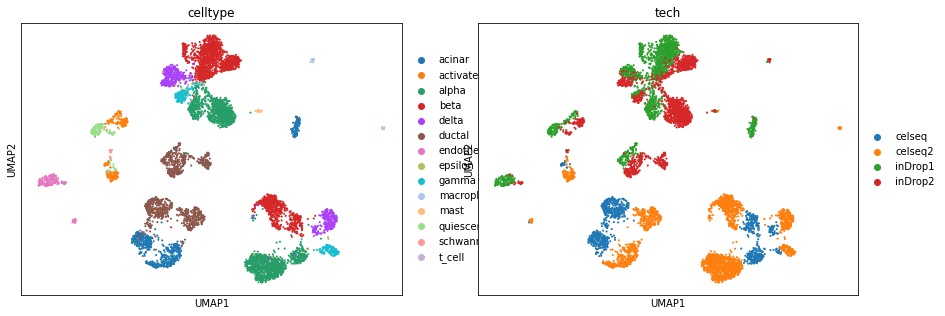

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

batch_key = "tech"
label_key = "celltype"

label = sc.pl.umap(adata, color=label_key, show=False, ax=ax1)
batch = sc.pl.umap(adata, color=batch_key, show=False, ax=ax2)

These plots clearly show that there are batch effects in this dataset. The two different technologies (cellseq and inDrop) are clearly separated and even for one technology there are differences between samples. If we consider the cell identity labels we see that cells which have the same are not always located near each other. If we were to perform a clustering analysis using this raw data we would probably end up with different clusters for each sample/identity combination which would be difficult to interpret at the annotation stage. We are also likely to overlook rare cell types which are not common enough in any single sample to produce their own cluster.

Now that we have confirmed there are batch effects to correct we can move on to the different integration methods.

## Batch-aware feature selection

For similar reasons to when only working with one sample we want to select a subset of genes to use for our analysis. However, when integrating multiple samples it is important that gene selection is performed in a batch aware way. This is because there may be a small cell population which is only present in one batch. Important genes for this population might not be variable across the whole datasets but should be when only considering one batch.

We can perform batch aware highly variable gene selection by setting the `batch_key` argument. **scanpy** will then calculate HVGs for each batch separately and combine the results.

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="cell_ranger", batch_key=batch_key)
adata
adata.var

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,highly_variable,means,dispersions,dispersions_norm,highly_variable_nbatches,highly_variable_intersection
A1BG,False,0.277454,2.866531,0.793526,1,False
A1CF,True,1.029200,2.514877,2.743373,3,False
A2M,True,0.150296,3.321352,3.592893,3,False
A2ML1,False,0.029536,1.173582,-0.009800,0,False
A4GALT,False,0.123540,2.816152,-0.453725,0,False
...,...,...,...,...,...,...
ZXDC,False,1.185176,2.242674,0.019727,0,False
ZYG11B,False,1.217888,2.152272,-0.331415,0,False
ZYX,False,1.046739,2.408431,1.389648,1,False
ZZEF1,False,0.810198,2.407011,-0.260825,0,False


We can see there are now some addtional columns in `var`:

* `highly_variable_nbatches` - The number of the batches where each gene was found to be highly variable
* `highly_variable_intersection` - Whether each genes was highly variable in every batch
* `highly_variable` - Whether each genes was selected as highly variable after combining the results from each batch 

Let's check how many batches each gene was variable in.

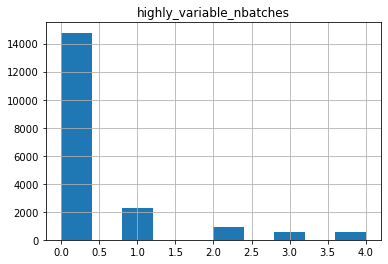

In [9]:
ax = adata.var.hist(column="highly_variable_nbatches")

In this case most genes are variable in all but it is still good practice to perform batch-aware gene selection in case they aren't.

> **How many genes to use?**
>
> This is a question which doesn't have a clear answer. The authors of the **scvi-tools** package which we use below recommend between 1000 and 10000 genes but depends on the context including the complexity of the dataset and the number of batches.
> In general it is better to select slightly too many genes than to select too few and risk removing genes which are important for a rare cell type.
> However, more genes will also increase the time required to run the integration methods.

We will create an object with just the selected genes to use for integration.

In [10]:
adata_hvg = adata[:, adata.var["highly_variable"]].copy()
adata_hvg

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'tech_colors'
    obsm: 'X_pca', 'X_umap', 'X_raw_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

## Integrating with scVI

The first integration method we will use is **scVI**. This method is based on a conditional variational autoencoder, a type of neural network which attempts to reconstruct the distribution of a dataset while considering differences between conditions (in this case batches). In benchmarking studies **scVI** has been shown to perform well across a range of datasets with a good balance of batch correction while conserving biological variability. **scVI** models raw counts directly so it is important that we provide it with a counts matrix rather than a normalised expression matrix.

### Data preparation

The first step in using **scVI** is prepare our AnnData object. This step stores some information which tells **scVI** important information such as which expresion matrix to use and what the batch key is.

In [11]:
scvi.data.setup_anndata(adata_hvg, layer="counts", batch_key=batch_key)
adata_hvg

INFO     Using batches from adata.obs["tech"]                                                
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6950 cells, 2000 vars, 4 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'tech_colors', '_scvi'
    obsm: 'X_pca', 'X_umap', 'X_raw_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities'

The fields created byh **scVI** are prefixed with `_scvi`. These are designed for internal use and should not be manually modified. Also note the general advice from **scVI** not to make any changes to our object until after the model is trained.

**scVI** also provides a handy function for viewing the current setup.

In [12]:
scvi.data.view_anndata_setup(adata_hvg)

Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 6950  │
│             Vars             │ 2000  │
│            Labels            │   1   │
│           Batches            │   4   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                SCVI Data Registry                 
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃       scvi-tools Location       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │     adata.layers['counts']      │
│ batch_indices │    adata.obs['_scvi_batch']     │
│ local_l_mean  │ adata.obs['_scvi_local_l_mean'] │
│  local_l_var  │ adata.obs['_scvi_local_l_var']  │
│    labels     │    adata.obs['_scvi_labels']    │
└───────────────┴─────────────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                    Batch Categories                    
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['tech'] │   celseq   │          0          │
│                   │  celseq2   │          1          │
│                   │  inDrop1   │          2          │
│                   │  inDrop2   │          3          │
└───────────────────┴────────────┴─────────────────────┘

Here we can see the number of batches, the labels for those batches and how **scVI** has encoded them. It is important to check this information to double check everything is as intended.

### Building the model

We can now construct an **scVI** model object. As well as the **scVI** model we use here the **scvi-tools** package contains various other models (we will use the **scANVI** model below). Note the warning about making sure that the X field contains unnormalised count data. In our case this is expected as some of our samples contain inferred counts (as mentioned above) but usually when you see this you should check that the layer provided to the setup function does actually contain count values.

In [13]:
model_scvi = scvi.model.SCVI(adata_hvg)
model_scvi

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

The model object contains the provided AnnData object as well as the neural network for the model itself. If we wanted to modify the structure of the network we could provide additional arguments to the model construction function but here we just use the defaults.

### Training the model

The model will be trained for a given number of _epochs_ (a training iteration where every cell is passed through the network). The following code is a suggested heuristic for reducing the number of epochs for larger datasets. Because this dataset has less than 20000 cells it returns the default value of 400.

In [14]:
max_epochs_scVI = np.min([round((20000 / adata.n_obs) * 400), 400])
max_epochs_scVI

400

We now train the model for the selected number of epochs.

In [15]:
model_scvi.train(max_epochs=max_epochs_scVI)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/400:   0%|                                                                                                                                                                  | 0/400 [00:00<?, ?it/s]

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 400/400: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [12:35<00:00,  1.89s/it, loss=996, v_num=1]


> **Early stopping**
>
> An alternative to manually setting the number of epochs is to set `early_stopping=True` in the training function. This will let **scVI** decide to stop training early depending on the convergence of the model.
> The exact conditions for stopping can be controlled by other parameters.

## Extracting the embedding 

The main result we want to extract from the trained model is the latent representation for each cell. This is an embedding where the batch effects have been removed. We store this in `obsm` with the key `X_scvi`.

In [16]:
adata_hvg.obsm["X_scVI"] = model_scvi.get_latent_representation()

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


### Calculate corrected UMAP

We will now visualise the data as we did before integrated. We calculate a new UMAP embedding but instead of finding nearest neighbours in PCA space we start with the corrected representation from **scVI**. We also store the new UMAP in `obsm` as `X_scVI_umap`.

In [17]:
sc.pp.neighbors(adata_hvg, use_rep="X_scVI", key_added="neighbors_scVI")
sc.tl.umap(adata_hvg, neighbors_key="neighbors_scVI")
adata_hvg.obsm["X_scVI_umap"] = adata_hvg.obsm["X_umap"]
adata_hvg

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'tech_colors', '_scvi', 'neighbors_scVI'
    obsm: 'X_pca', 'X_umap', 'X_raw_umap', 'X_scVI', 'X_scVI_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities', 'neighbors_scVI_distances', 'neighbors_scVI_connectivities'

Once we have the new UMAP representation we can plot it coloured by batch and identity labels as before.

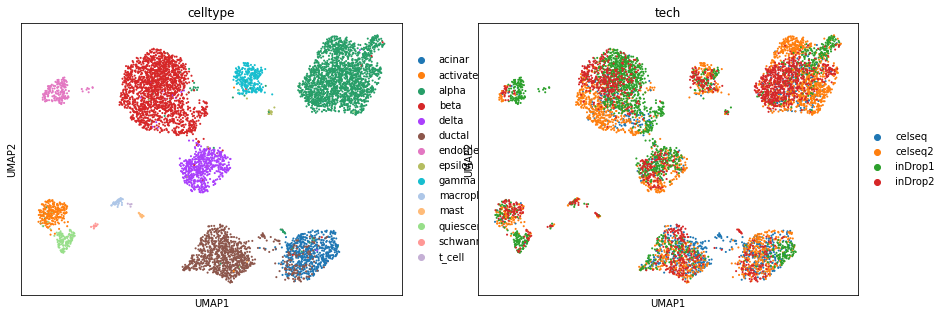

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

label = sc.pl.umap(adata_hvg, color=label_key, show=False, ax=ax1)
batch = sc.pl.umap(adata_hvg, color=batch_key, show=False, ax=ax2)

This looks much better! Before the various batches were separated and the same cell identity in different batches were far apart from each other. Now the batches are all mixed with each other and we have a single blob for each cell identity label.

In many cases we would not already have identity labels so from this stage we would continue with clustering, annotation and further analysis as described in other sections.

## Integrating with scANVI

When performing integration with **scVI** we pretended that we didn't already have any cell labels (although we showed them in plots). While this scenario is common there are some cases where we do know something about cell identity in advance. Most often this is when we want to combine one or more publically available datasets with data from a new study. When we have labels for at least some of the cells we can used **scANVI**. This is an extension of the **scVI** model that knows about cell labels as well as batches. Because it has this extra information it can try to keep the differences between cell labels while removing batch effects. Benchmarking suggests that **scANVI** tends to better preserve biological signals compared to **scVI** but sometimes it is not as effective at removing batch effects.

We start by setting up our AnnData object as before, but now we provide a label key as well as the batch key.

In [19]:
scvi.data.setup_anndata(adata_hvg, layer="counts", batch_key=batch_key, labels_key=label_key)
scvi.data.view_anndata_setup(adata_hvg)

INFO     Using batches from adata.obs["tech"]                                                
INFO     Using labels from adata.obs["celltype"]                                             
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 6950 cells, 2000 vars, 4 batches, 
         14 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0     
         extra continuous covariates.                                                        
INFO     Please do not further modify adata until model is trained.                          


Anndata setup with scvi-tools version 0.13.0.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 6950  │
│             Vars             │ 2000  │
│            Labels            │  14   │
│           Batches            │   4   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

                SCVI Data Registry                 
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃       scvi-tools Location       ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │     adata.layers['counts']      │
│ batch_indices │    adata.obs['_scvi_batch']     │
│ local_l_mean  │ adata.obs['_scvi_local_l_mean'] │
│  local_l_var  │ adata.obs['_scvi_local_l_var']  │
│    labels     │    adata.obs['_scvi_labels']    │
└───────────────┴─────────────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃     Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │       acinar       │          0          │
│                       │ activated_stellate │          1          │
│                       │       alpha        │          2          │
│                       │        beta        │          3          │
│                       │       delta        │          4          │
│                       │       ductal       │          5          │
│                       │    endothelial     │          6          │
│                       │      epsilon       │          7          │
│                       │       gamma        │          8          │
│                       │     macrophage     │          9          │
│                       │        mast        │         10          │
│                       │ quiescent_stellate │         11          │
│                       │      schwann       │         12          │
│                       │       t_cell       │         13          │
└───────────────────────┴────────────────────┴─────────────────────┘

                    Batch Categories                    
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location  ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['tech'] │   celseq   │          0          │
│                   │  celseq2   │          1          │
│                   │  inDrop1   │          2          │
│                   │  inDrop2   │          3          │
└───────────────────┴────────────┴─────────────────────┘

We can see that our setup now contains information about the cell identity labels.

The next step is now to create a **scANVI** model object. Note that now we provide the **scVI** model from the previous section rather than the AnnData object. This is because **scANVI** works by refining the model from **scVI** using the cell labels. If we had not already created and trained an **scVI** model we would need to do that first before we could use **scANVI**.

We also need to provide **scANVI** with a label for any cells without a label in the dataset. In this case all our cells are labelled so we just provide a dummy value but often it is important to make sure this is correct.

In [20]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(model_scvi, unlabeled_category="unlabelled")
model_scanvi

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


ScanVI Model with the following params: 
unlabeled_category: unlabelled, n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, 
dispersion: gene, gene_likelihood: zinb
Training status: Not Trained

To print summary of associated AnnData, use: scvi.data.view_anndata_setup(model.adata)

This model object is very similar to what we saw before for **scVI**. As mentioned previously we could modify the structure of the model network but here we just use the default.

Again we have a heuristic for selecting the number of training epochs. Note that this is much fewer than before as we are just refining the **scVI** model, rather than training a whole network from scratch.

In [21]:
max_epochs_scANVI = int(np.min([10, np.max([2, round(max_epochs_scVI / 3.0)])]))
model_scanvi.train(max_epochs=max_epochs_scANVI)

INFO     Training for 10 epochs.                                                             


GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 1/10:   0%|                                                                                                                                                                    | 0/10 [00:00<?, ?it/s]

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:433: UserWarning: The value argument must be within the support of the distribution
  warnings.warn(


Epoch 10/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.91s/it, loss=1.06e+03, v_num=1]


We can extract the new latent representation from the model and create a new UMAP embedding as we did for **scVI**. This time we store it using the key `X_scANVI_umap`.

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scvi/model/base/_base_model.py:149: UserWarning: Make sure the registered X field in anndata contains unnormalized count data.
  warnings.warn(


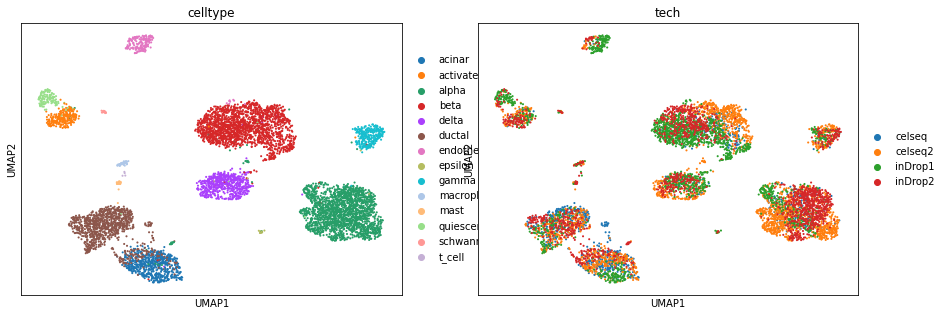

In [22]:
adata_hvg.obsm["X_scANVI"] = model_scanvi.get_latent_representation()
sc.pp.neighbors(adata_hvg, use_rep="X_scANVI", key_added="neighbors_scANVI")
sc.tl.umap(adata_hvg, neighbors_key="neighbors_scANVI")
adata_hvg.obsm["X_scANVI_umap"] = adata_hvg.obsm["X_umap"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
label = sc.pl.umap(adata_hvg, color=label_key, show=False, ax=ax1)
batch = sc.pl.umap(adata_hvg, color=batch_key, show=False, ax=ax2)

By looking at the UMAP representation it is difficult to tell the difference between **scANVI** and **scVI** but when the effect of the refinement has been quantified it has been shown to better preserve biological variation.

## BBKNN

In [23]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 10000 else 3

In [24]:
adata_hvg.X = adata_hvg.layers["logcounts"]
sc.pp.pca(adata_hvg)
bbknn.bbknn(adata_hvg, batch_key="tech", neighbors_within_batch=neighbors_within_batch)
adata_hvg

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'tech_colors', '_scvi', 'neighbors_scVI', 'neighbors_scANVI'
    obsm: 'X_pca', 'X_umap', 'X_raw_umap', 'X_scVI', 'X_scVI_umap', 'X_scANVI', 'X_scANVI_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts'
    obsp: 'distances', 'connectivities', 'neighbors_scVI_distances', 'neighbors_scVI_connectivities', 'neighbors_scANVI_distances', 'neighbors_scANVI_connectivities'

In [25]:
sc.tl.umap(adata, neighbors_key="neighbors")
adata.obsm["X_BBKNN_umap"] = adata.obsm["X_umap"]

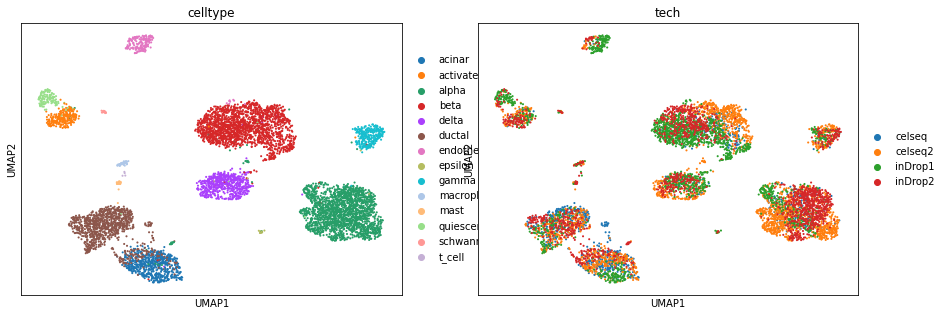

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
celltype = sc.pl.umap(adata_hvg, color="celltype", show=False, ax=ax1)
tech = sc.pl.umap(adata_hvg, color="tech", show=False, ax=ax2)

## COMBAT

In [27]:
adata_hvg.X = adata_hvg.layers["logcounts"]
sc.pp.combat(adata_hvg, key="tech", inplace=True)
adata_hvg.layers["combat"] = adata_hvg.X
adata_hvg

/Users/luke.zappia/miniconda/envs/bp-integration/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'tech', 'celltype', 'size_factors', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'celltype_colors', 'tech_colors', '_scvi', 'neighbors_scVI', 'neighbors_scANVI'
    obsm: 'X_pca', 'X_umap', 'X_raw_umap', 'X_scVI', 'X_scVI_umap', 'X_scANVI', 'X_scANVI_umap'
    varm: 'PCs'
    layers: 'counts', 'logcounts', 'combat'
    obsp: 'distances', 'connectivities', 'neighbors_scVI_distances', 'neighbors_scVI_connectivities', 'neighbors_scANVI_distances', 'neighbors_scANVI_connectivities'

In [28]:
sc.pp.pca(adata_hvg)
sc.pp.neighbors(adata_hvg, key_added="neighbors_COMBAT")
sc.tl.umap(adata_hvg, neighbors_key="neighbors_COMBAT")
adata.obsm["X_COMBAT_umap"] = adata.obsm["X_umap"]

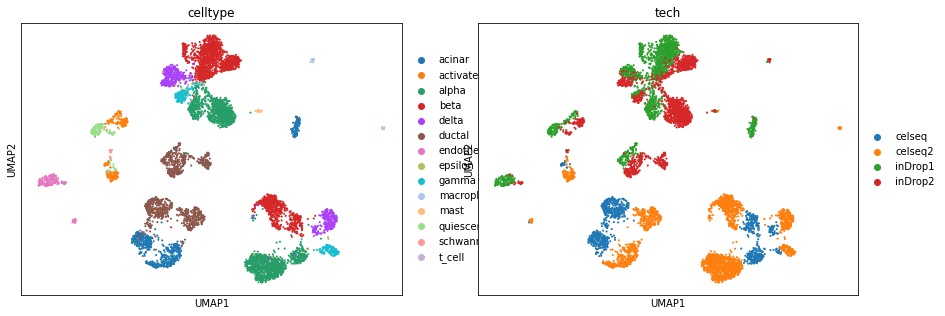

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
celltype = sc.pl.umap(adata, color="celltype", show=False, ax=ax1)
tech = sc.pl.umap(adata, color="tech", show=False, ax=ax2)

## Benchmarking your own integration

* How to use scIB
* Interpreting benchmarks?
* Probably just text (hard to run all the methods, could maybe compare whatever methods are run)

## Session information

In [30]:
import session_info


session_info.show()